### Encoding Words

In [126]:
from tensorflow.keras.preprocessing.text import Tokenizer
kalimat = [
'saya suka kucing',
'saya suka tikus']

Gunakan tokenizer

In [127]:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(kalimat)

In [128]:
word_index = tokenizer.word_index
word_index

{'saya': 1, 'suka': 2, 'kucing': 3, 'tikus': 4}

Gunakan Sequences

In [129]:
sequences = tokenizer.texts_to_sequences(kalimat)
print("Word Index : ", word_index)
print("Sequences : ", sequences)

Word Index :  {'saya': 1, 'suka': 2, 'kucing': 3, 'tikus': 4}
Sequences :  [[1, 2, 3], [1, 2, 4]]


### Padding

In [130]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences, maxlen=5, padding='post')
print(padded)

[[1 2 3 0 0]
 [1 2 4 0 0]]


### Modelling

In [131]:
import pandas as pd
import tensorflow as tf

In [132]:
df = pd.read_json("https://raw.githubusercontent.com/Echo271/sarcasm-detection/main/sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [133]:
sentences = df['headline']
labels = df['is_sarcastic']


In [134]:
training_size = 20000
# Split data kalimat
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
# Split data label
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [135]:
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = ""

In [136]:
# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [137]:
# Generate kalimat ke dalam dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [138]:
# Generate sequences dan pad pada training data
training_sequences = tokenizer.texts_to_sequences(training_sentences)

training_padded = pad_sequences(training_sequences, maxlen=max_length,
padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
padding=padding_type, truncating=trunc_type)

In [139]:
# Parameter
embedding_dim = 16
lstm_dim = 32
dense_dim = 24
# Model dengan LSTM
model_lstm = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [140]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [141]:
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=10,validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 31s 46ms/step - loss: 0.4135 - accuracy: 0.7949 - val_loss: 0.3342 - val_accuracy: 0.8520
Epoch 2/10
625/625 [==============================] - 32s 51ms/step - loss: 0.2115 - accuracy: 0.9146 - val_loss: 0.3614 - val_accuracy: 0.8560
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1316 - accuracy: 0.9513 - val_loss: 0.4216 - val_accuracy: 0.8502
Epoch 4/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0810 - accuracy: 0.9706 - val_loss: 0.5059 - val_accuracy: 0.8496
Epoch 5/10
625/625 [==============================] - 32s 52ms/step - loss: 0.0491 - accuracy: 0.9834 - val_loss: 0.6493 - val_accuracy: 0.8420
Epoch 6/10
625/625 [==============================] - 32s 52ms/step - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.7109 - val_accuracy: 0.8362
Epoch 7/10
625/625 [==============================] - 32s 52ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.9065 - val_accuracy:

In [142]:
ypred = (model_lstm.predict(testing_padded > 0.5)).astype("int32")

210/210 [==============================] - 4s 16ms/step


In [160]:
dfTest = df.loc[training_size:,'headline':'is_sarcastic']
dfTest['PredictedLabel'] = ypred

dfTest.loc[lambda df: df['is_sarcastic'] != df['PredictedLabel']]

,headline,is_sarcastic,PredictedLabel
20000,pediatricians announce 2011 newborns are uglie...,1,0
20003,bausch & lomb introduces line of aviator contacts,1,0
20005,report: sky normal today,1,0
20007,friend who listened to podcast on watergate bu...,1,0
20008,economists warn new graduates may have to toug...,1,0
...,...,...,...
26693,new bailiff tired of hearing how old bailiff d...,1,0
26694,breaking: 'the onion' in kill range of boston ...,1,0
26695,seaworld crowd applauds for dolphin playfully ...,1,0
26702,pentagon to withhold budget figures out of res...,1,0


In [161]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [170]:
dfNotSarcas = df[df['is_sarcastic'] == 0]
dfSarcas = df[df['is_sarcastic'] == 1]

In [168]:
import matplotlib.pyplot as plt

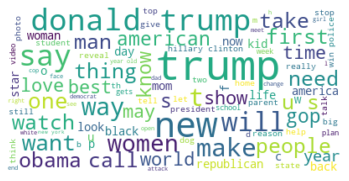

In [172]:
text = dfNotSarcas['headline'].to_string()
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

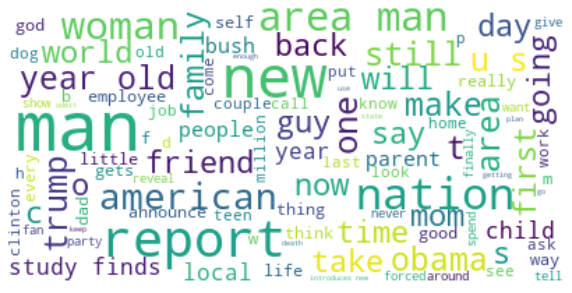

In [174]:
text = dfSarcas['headline'].to_string()
# Create and generate a word cloud image:

plt.figure(figsize=[10,15])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()